In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sys.path.append("C:/Users/jakob/Documents/MLandData/OtherFiles")
import Alexandria as lib

alpha = 0.9
beta = 0.2
gamma = 0.1

lambdas = [1,5]


n = 10
T = 100

Gamma = np.array([1-gamma,0,gamma,0,1-gamma,gamma,beta/2,beta/2,1-beta]).reshape((3,3))


def PZ1(c):
    if c == 0:
        return 1 - alpha
    if c == 1:
        return alpha
    if c == 2:
        return 0.5


In [2]:
def simulate(n,T,C0 = 0):
    C = np.empty(T,dtype = int)
    z = np.empty((T,n),dtype = int)
    x = np.empty((T,n))

    for t in range(T):

        C[t] = np.random.choice([0,1,2],p = Gamma[C[t-1],:]) if t > 0 else C0

        for i in range(n):
            z[t,i] = np.random.random() < PZ1(C[t])
            x[t,i] = np.random.poisson( lambdas[ z[t,i] ] ) 

        
    return (C,z,x)

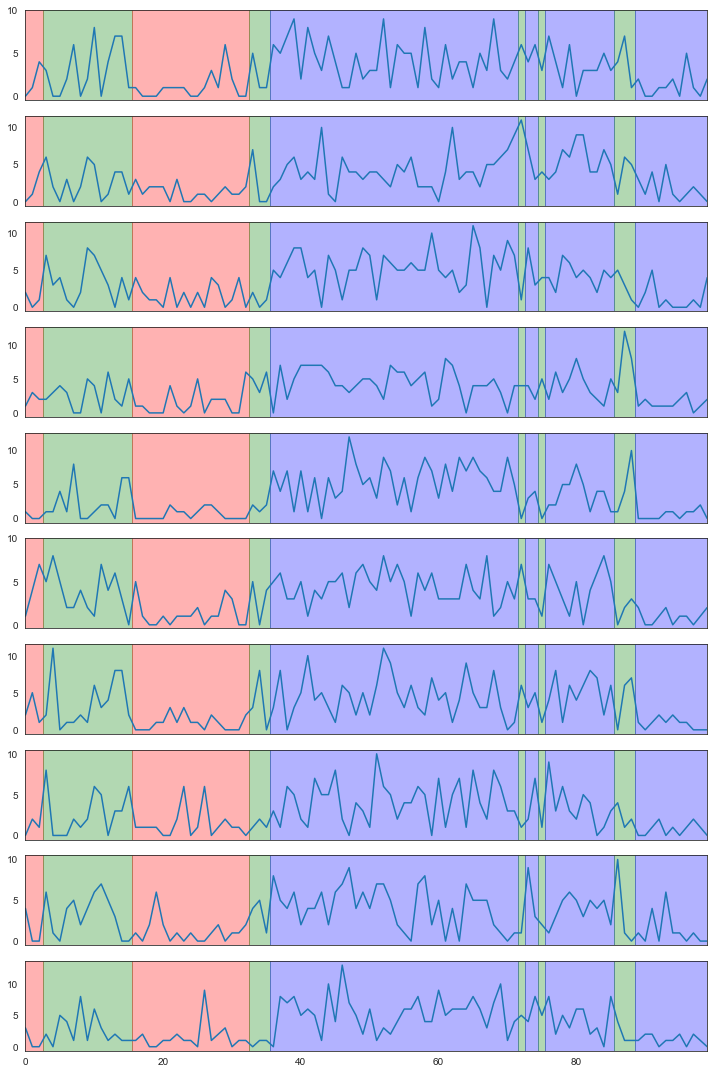

In [82]:
C, z, x = simulate(n,T,0)


fig, axs = plt.subplots(n,1,figsize = (10,15),sharex=True)

x_split = [x[C == i] for i in range(3)]
x_axis_split = [np.array([xx for xx in range(len(C))])[C == i] for i in range(3)]

for nn in range(n):
    axs[nn].plot(x[:,nn])

    cc = C[0]
    lt = 0
    for t in range(1,T):
        if cc != C[t]:
            axs[nn].axvspan(lt-0.5, t-0.5, alpha=0.3, color=['red','blue','green'][cc])
            cc = C[t]
            lt = t
    axs[nn].axvspan(lt-0.5,T-0.5, alpha=0.3, color=['blue','red','green'][cc])

    axs[nn].set_xlim(0,T-1)
    axs[nn].set_yticks([0,5,10])


    # for i in range(len(x_split)):
    #     axs[nn].plot(x_axis_split[i], x_split[i][:,nn], '.', markersize = 10)

plt.tight_layout(pad = 1)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 59 60]
[20 21 22 23 24 25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86
 87 88 89 90 91 92 93]
[16 17 18 19 26 47 48 49 50 51 52 53 54 55 56 57 58 61 62 63 64 94 95 96
 97 98 99]


In [7]:
C == 1

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [52]:
C, z, X = simulate(25,20000,0)

X_train, X_test, y_train, y_test = train_test_split(X,C, test_size = 0.1) 

clf = LogisticRegression().fit(X_train,y_train)

C_pred = clf.predict(X_test)
